# Execute YOLOv3 vehicle detector
This notebook uses the generated data to run vehicle detection

## Usage:
Run all cells

## Requirements:
./content/datasets/h5_out/raw_image_real.h5\
./content/datasets/h5_out/raw_image_sim.h5\
./content/datasets/h5_out/semantic_id_list_real.h5\
./content/datasets/h5_out/semantic_id_list_sim.h5\
./content/datasets/h5_out/bounding_boxes_sim.h5\
./content/datasets/h5_out/bounding_boxes_real.h5

Please refer to [KITTI 1] to produce h5_out data

./content/output_plots/[domain_type] folder generated in [PIPELINE 1]

## Outputs:
./content/output_plots/[domain_type]/[domain_type]_pred\
./content/output_plots/[domain_type]/[domain_type]_yolo_loss\
./content/output_plots/[domain_type]/[domain_type]_yolo_conf\
./content/output_plots/[domain_type]/[domain_type]_yolo_att

In [ ]:
import h5py
import numpy as np
import PIL.Image as Image
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import re
from collections import OrderedDict

import numpy as np
import pandas as pd
import cv2, os, glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.utils import plot_model
from scipy.optimize import linear_sum_assignment


YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

## Prepare data

In [ ]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_h5_to_dictionary(file_path):
    data_dict = OrderedDict()
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            array_list = []
            group = hf[key]
            sorted_dataset_names = sorted(group.keys(), key=natural_sort_key)
            for dataset_name in sorted_dataset_names:
                array_list.append(np.array(group[dataset_name]))
            data_dict[key] = array_list
    return data_dict

def find_lowest_dimensions(images_list1, images_list2):
    lowest_height = min(images_list1[0].shape[0], images_list2[0].shape[0])
    lowest_width = min(images_list1[0].shape[1], images_list2[0].shape[1])
    return lowest_height, lowest_width

def crop_images_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width,:] for image in images_list]
    return cropped_images

def crop_1d_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width] for image in images_list]
    return cropped_images

In [ ]:
file_path = './content/datasets/h5_out/raw_image_sim.h5'
loaded_dictionary_images_sim=load_h5_to_dictionary(file_path)
file_path = './content/datasets/h5_out/raw_image_real.h5'
loaded_dictionary_images_real=load_h5_to_dictionary(file_path)
file_path = './content/datasets/h5_out/semantic_id_list_real.h5'
loaded_semantic_id_real=load_h5_to_dictionary(file_path)
file_path = './content/datasets/h5_out/semantic_id_list_sim.h5'
loaded_semantic_id_sim=load_h5_to_dictionary(file_path)


file_path = './content/datasets/h5_out/bounding_boxes_sim.h5'
loaded_bounding_sim=load_h5_to_dictionary(file_path)

file_path = './content/datasets/h5_out/bounding_boxes_real.h5'
loaded_bounding_real=load_h5_to_dictionary(file_path)


dataset_index_list_test=["0001","0002","0006","0018","0020"]
lowest_height=10000
lowest_width=10000

for dataset_index in dataset_index_list_test:
  height, width = find_lowest_dimensions(loaded_dictionary_images_real[dataset_index], loaded_dictionary_images_sim[dataset_index])
  lowest_height=min(height,lowest_height)
  lowest_width=min(width,lowest_width)
print(lowest_height,lowest_width)

for dataset_index in dataset_index_list_test:

    loaded_dictionary_images_real[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_real[dataset_index], lowest_height, lowest_width)
    loaded_dictionary_images_sim[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_sim[dataset_index], lowest_height, lowest_width)

    
    loaded_semantic_id_real[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_real[dataset_index], lowest_height, lowest_width)
    loaded_semantic_id_sim[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_sim[dataset_index], lowest_height, lowest_width)

train_indexes_gan = {}
test_indexes_gan = {}


pattern = 'ttvttvttvt'
pattern_pointer = 0
for dataset_index in dataset_index_list_test:
  train_dataset_indices_inner = []
  test_dataset_indices_inner = []

  for index in range(0, min(len(loaded_dictionary_images_real[dataset_index]),len(loaded_dictionary_images_sim[dataset_index]))):
    pattern_char = pattern[pattern_pointer]
    if pattern_char == 't':
        train_dataset_indices_inner.append(index)
    else:
        test_dataset_indices_inner.append(index)
    pattern_pointer = (pattern_pointer + 1) % len(pattern)
  train_indexes_gan[dataset_index]=train_dataset_indices_inner
  test_indexes_gan[dataset_index]=test_dataset_indices_inner

print("GAN train and test")
for dataset_index in dataset_index_list_test:
    print("Dataset", dataset_index)
    print("Train: ",len(train_indexes_gan[dataset_index]))
    print("Trest: ",len(test_indexes_gan[dataset_index]))

boxes_real_dict={}

for dataset_index in dataset_index_list_test:
    boxes_real={}
    for image_index,label,x_min, y_min, x_max, y_max in loaded_bounding_real[dataset_index]:
       if image_index not in boxes_real:
           boxes_real[image_index] = [[label,x_min, y_min, x_max, y_max]]
       else:
           boxes_real[image_index].append([label,x_min, y_min, x_max, y_max])
    
    
    boxes_real_dict[dataset_index]=boxes_real


boxes_sim_dict={}

for dataset_index in dataset_index_list_test:
    boxes_sim={}
    for image_index,label,x_min, y_min, x_max, y_max in loaded_bounding_sim[dataset_index]:
       if image_index not in boxes_sim:
           boxes_sim[image_index] = [[label,x_min, y_min, x_max, y_max]]
       else:
           boxes_sim[image_index].append([label,x_min, y_min, x_max, y_max])
    
    
    boxes_sim_dict[dataset_index]=boxes_sim

# YOLO v3 codebase

In [6]:
def load_darknet_weights(model, weights_file, tiny = False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.prod(conv_shape))
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

def broadcast_iou(box_1, box_2):
    '''
    box_1: (..., (x1, y1, x2, y2))
    box_2: (N, (x1, y1, x2, y2))
    '''

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) - tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) - tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

def freeze_all(model, frozen = True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    return img

def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis = -1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0 : 2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(
            img, class_names[classes[i]],
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
            8, (0, 0, 255), 2
        )
    return img

def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    N = tf.shape(y_true)[0]
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2
                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1
    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

def transform_targets(y_train, anchors, anchor_masks, classes):
    y_outs = []
    grid_size = 13
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)
    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2
    return tuple(y_outs)

class BatchNormalization(tf.keras.layers.BatchNormalization):

    def call(self, x, training = False):
        if training is None:
            traininig = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)
    
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x
def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def yolo_boxes(pred, anchors, classes):
    '''pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))'''
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box

def yolo_nms(outputs, anchors, masks, classes):
    '''boxes, conf, type'''
    b, c, t = [], [], []
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,
        score_threshold = 0.5
    )
    return boxes, scores, classes, valid_detections

def YoloV3(anchors, masks, size=None, channels=3, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)
    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),name='yolo_boxes_2')(output_2)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, [outputs,output_0,output_1,output_2], name='yolov3')

def draw_gt(img, boxes):
    for box in boxes:
        xy, confidence = box[:4], box[4]
        xy = [xy[i] for i in range(4)]
        thickness = (512 + 512) // 200
        for t in np.linspace(0, 1, thickness):
            xy[0], xy[1] = xy[0] + t, xy[1] + t
            xy[2], xy[3] = xy[2] - t, xy[3] - t
            if xy[3] >= xy[1] and xy[2] >= xy[0]:
                img = cv2.rectangle(img, (int(xy[0]),int(xy[1])),(int(xy[2]),int(xy[3])), (0, 255, 0), 2)

    return img

def calculate_iou(box1, box2):
    x1, y1, w1, h1, _ = box1
    x2, y2, w2, h2, _ = box2

    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = max(0, min(x1 + w1, x2 + w2) - x_intersection)
    h_intersection = max(0, min(y1 + h1, y2 + h2) - y_intersection)

    intersection_area = w_intersection * h_intersection
    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersection_area / (box1_area + box2_area - intersection_area + 1e-6)
    return iou


def calculate_loss(predicted_boxes, gt_boxes,img2,plot_if):
    num_pred_boxes = len(predicted_boxes)
    num_gt_boxes = len(gt_boxes)
    
    if num_pred_boxes == 0 and num_gt_boxes == 0:
        return 0.0
    
    iou_matrix = np.zeros((num_pred_boxes, num_gt_boxes))
    
    if num_pred_boxes > 0 and num_gt_boxes > 0:
        for i in range(num_pred_boxes):
            for j in range(num_gt_boxes):
                iou_matrix[i, j] = calculate_iou(predicted_boxes[i], gt_boxes[j])
        
        pred_indices, gt_indices = linear_sum_assignment(-iou_matrix)
    else:
        pred_indices = []
        gt_indices = []
    
    false_neg_loss = 0
    false_pos_loss = 0
    correct_match_loss = 0
    linspace_gt = list(range(0, num_gt_boxes))
    linspace_pred = list(range(0, num_pred_boxes))

    
    missing_gt=[item for item in linspace_gt if item not in gt_indices]
    missing_pred=[item for item in linspace_pred if item not in pred_indices]
    for missing_idx in missing_gt:
        xy, confidence = gt_boxes[missing_idx][:4], gt_boxes[missing_idx][4]
        width = abs(int(xy[2]) - int(xy[0]))
        height = abs(int(xy[3]) - int(xy[1]))
        area = width * height
        false_neg_loss+=area
    for missing_idx in missing_pred:
        xy, confidence = predicted_boxes[missing_idx][:4], predicted_boxes[missing_idx][4]
        width = abs(int(xy[2]) - int(xy[0]))
        height = abs(int(xy[3]) - int(xy[1]))
        area = width * height
        false_pos_loss+=area

    for pred_idx, gt_idx in zip(pred_indices, gt_indices):
        x1, y1, w1, h1, _ = predicted_boxes[pred_idx]
        x2, y2, w2, h2, _ = gt_boxes[gt_idx]
    
        x_intersection = max(x1, x2)
        y_intersection = max(y1, y2)
        w_intersection = max(0, min(x1 + w1, x2 + w2) - x_intersection)
        h_intersection = max(0, min(y1 + h1, y2 + h2) - y_intersection)
    
        intersection_area = w_intersection * h_intersection
        box1_area = w1 * h1
        box2_area = w2 * h2
        correct_match_loss += box2_area - intersection_area

    if plot_if:
        for pred_idx, gt_idx in zip(pred_indices, gt_indices):
            img3=img2.copy()
            xy, confidence = gt_boxes[gt_idx][:4], gt_boxes[gt_idx][4]
            xy = [xy[i] for i in range(4)]
            x0, y0 = xy[0], xy[1]
    
            thickness = (512 + 512) // 200
            for t in np.linspace(0, 1, thickness):
                xy[0], xy[1] = xy[0] + t, xy[1] + t
                xy[2], xy[3] = xy[2] - t, xy[3] - t
                if xy[3] >= xy[1] and xy[2] >= xy[0]:
                    img3 = cv2.rectangle(img3, (int(xy[0]),int(xy[1])),(int(xy[2]),int(xy[3])), (0, 255, 0), 2)
            xy, confidence = predicted_boxes[pred_idx][:4], predicted_boxes[pred_idx][4]
            xy = [xy[i] for i in range(4)]
            x0, y0 = xy[0], xy[1]
    
            thickness = (512 + 512) // 200
            for t in np.linspace(0, 1, thickness):
                xy[0], xy[1] = xy[0] + t, xy[1] + t
                xy[2], xy[3] = xy[2] - t, xy[3] - t
                if xy[3] >= xy[1] and xy[2] >= xy[0]:
                    img3 = cv2.rectangle(img3, (int(xy[0]),int(xy[1])),(int(xy[2]),int(xy[3])), (255, 255, 0), 2)
            fig, axes = plt.subplots(figsize = (16, 16))
            plt.imshow(img3)
            plt.show()

    print("false pos n. ",len(missing_pred), "loss: ", false_pos_loss)
    print("false neg n. ",len(missing_gt), "loss: ", false_neg_loss)
    print("matched n. ",len(pred_indices), "loss: ", correct_match_loss/max(1,len(pred_indices)))
    cumulative_loss=(false_pos_loss)*0.4+(false_neg_loss)*0.4 +correct_match_loss/max(1,len(pred_indices))*0.2
    print("cumulative loss: ",str(cumulative_loss))
    return cumulative_loss


# Output calculations

In [28]:
def generate_grad_cam(output, img,img2, target_class):
    grad_cams = []
    combined_heatmap = np.zeros((img2.shape[0], img2.shape[1]))

    for anchor_box_index in range(output.shape[3]):
        cam = output[0, :, :, anchor_box_index, target_class]
        cam = np.maximum(cam, 0)
        if(np.max(cam)>0):
            cam /= np.max(cam)
        cam = cv2.resize(cam, (img2.shape[1], img2.shape[0]))
        grad_cams.append(cam)
        combined_heatmap += cam

    combined_heatmap = np.maximum(combined_heatmap, 0)
    combined_heatmap /= np.max(combined_heatmap)

    return grad_cams, combined_heatmap


def display_heatmaps_with_image(grad_cams, combined_heatmap, img):
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(combined_heatmap, cmap='jet')
    plt.title('Combined Grad-CAM Overlay')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.show()


def predict(yolo,img_paths,save_path,heat_save_path,loss_path,confi_path,boxes_dict,class_names, visualize, figsize = (16, 16)):
    for image_file in img_paths:
        img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
        wh = np.flip(img.shape[0:2])
        img = tf.expand_dims(img, 0)
        img = transform_images(img, 416)
        load_darknet_weights(yolo, './content/yolo/yolov3.weights', False)
        index=int(image_file.split("output_plots/")[-1].split("_")[-1].split(".png")[0])
        dataset_index=image_file.split("/")[-1].split("_")[-2]
        if index in boxes_dict[dataset_index]:
            data=np.array(boxes_dict[dataset_index][index])
            mask = np.isin(data[:, 0], [3])
            modified_data = np.concatenate((data[mask, 1:], np.ones((np.sum(mask), 1))), axis=1)
            gt_dict = modified_data.astype(float)
        else:
            data=np.array([])
            gt_dict = data.astype(float)
        outputs = yolo.predict(img)
        boxes, scores, classes, nums = outputs[0]
        output_0=outputs[-3]
        output_1=outputs[-2]
        output_2=outputs[-1]

        img2 = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        
        
        total_heatmap = np.zeros((img2.shape[0], img2.shape[1]))
    
        for target_class in [0,1,2,3,7]:
            grad_cams_0, combined_heatmap_0 = generate_grad_cam(output_0, img,img2, target_class)
            grad_cams_1, combined_heatmap_1 = generate_grad_cam(output_1, img,img2, target_class)
            grad_cams_2, combined_heatmap_2 = generate_grad_cam(output_2, img,img2, target_class)
            
        
            merged_heatmap = combined_heatmap_0 + combined_heatmap_1 + combined_heatmap_2
        
            merged_heatmap = np.maximum(merged_heatmap, 0)
            merged_heatmap /= np.max(merged_heatmap)

            
            total_heatmap += merged_heatmap
        
        class_2_boxes = [(box[0], box[1], box[2], box[3], score) for box, score, class_id in zip(boxes[0], scores[0], classes[0]) if class_id == 2]
        class_2_boxes = np.array(class_2_boxes)
        if(len(class_2_boxes>0)):
            class_2_boxes[:, 0] *= wh[0]
            class_2_boxes[:, 2] *= wh[0]
            class_2_boxes[:, 1] *= wh[1]
            class_2_boxes[:, 3] *= wh[1]
        
        
        save_filename = f"{save_path}{dataset_index}_{index}.png"
        heat_save_filename = f"{heat_save_path}{dataset_index}_{index}.png"
        loss_filename = f"{loss_path}{dataset_index}_{index}.txt"
        confidence_filename = f"{confi_path}{dataset_index}_{index}.txt"
        
        
        yolo_loss=calculate_loss(class_2_boxes, gt_dict,img2,False)
        print(len(class_2_boxes.shape))
        if len(class_2_boxes.shape)!=2:
            confidence=0.0
        else:
            confidence=np.mean(class_2_boxes[:,4])

        
        if index in boxes_dict[dataset_index]:
            img2 = draw_gt(img2,gt_dict)
        img2 = draw_outputs(img2, (boxes, scores, classes, nums), class_names)

        merged_heatmap_normalized = merged_heatmap / np.max(merged_heatmap)

        heatmap_color = cv2.applyColorMap((merged_heatmap_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)

        
        
        
        if visualize:
            fig, axes = plt.subplots(figsize = figsize)
            plt.imshow(img2)
            plt.show()
            print("YOLO loss: ",yolo_loss)
            print("-----------")
        else:
            
            cv2.imwrite(save_filename, cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
            cv2.imwrite(heat_save_filename, heatmap_color)
            print(save_filename)
            with open(loss_filename, 'w') as f:
                f.write(str(yolo_loss))
            with open(confidence_filename, 'w') as f:
                f.write(str(confidence))

def yolo_runner(model_type,yolo,source_name,boxes_dict,class_names):
    load_darknet_weights(yolo, './content/yolo/yolov3.weights', False)
    img_paths = sorted(glob.glob('./content/output_plots/'+str(model_type)+'/'+str(source_name)+'/*.png'))
    save_path='./content/output_plots/'+str(model_type)+'/'+str(source_name)+'_pred/'
    loss_path='./content/output_plots/'+str(model_type)+'/'+str(source_name)+'_yolo_loss/'
    heat_save_path='./content/output_plots/'+str(model_type)+'/'+str(source_name)+'_yolo_att/'
    confi_path='./content/output_plots/'+str(model_type)+'/'+str(source_name)+'_yolo_conf/'
    visualize=False
    os.makedirs(save_path, exist_ok=True)
    os.makedirs(loss_path, exist_ok=True)
    os.makedirs(heat_save_path, exist_ok=True)
    os.makedirs(confi_path, exist_ok=True)
    predict(yolo,img_paths,save_path,heat_save_path,loss_path,confi_path,boxes_dict,class_names,visualize, figsize = (20, 20))

In [ ]:
yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

yolo_tiny_anchors = np.array([
    (10, 14), (23, 27), (37, 58),
    (81, 82), (135, 169), (344, 319)],
    np.float32) / 416

yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]]) 

class_names = [
    'person', 'bicycle','car','motorbike','aeroplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench',
    'bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
    'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove',
    'skateboard','surfboard','tennis racket','bottle','wine glass','cup',
    'fork','knife','spoon','bowl','banana','apple','sandwich','orange',
    'broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa',
    'pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]

yolo = YoloV3(yolo_anchors, yolo_anchor_masks, classes = 80)

## Test execution

0001
0001


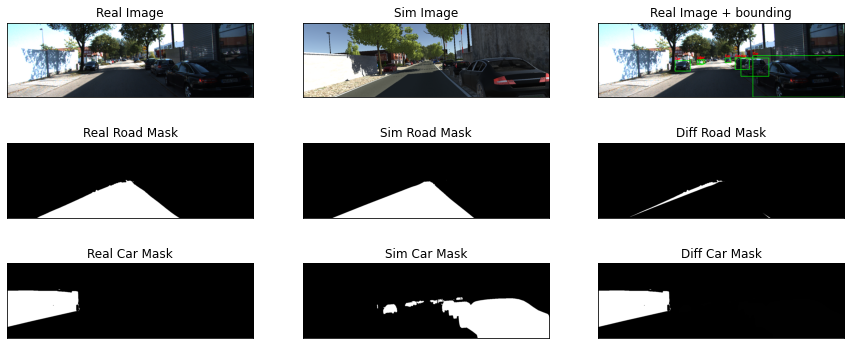

0002
0002


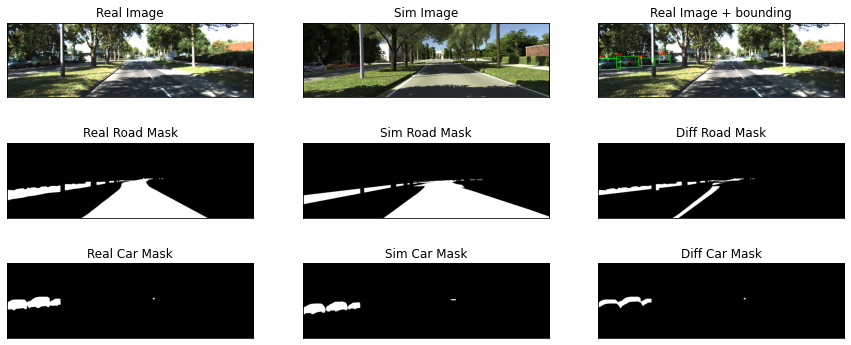

0006
0006


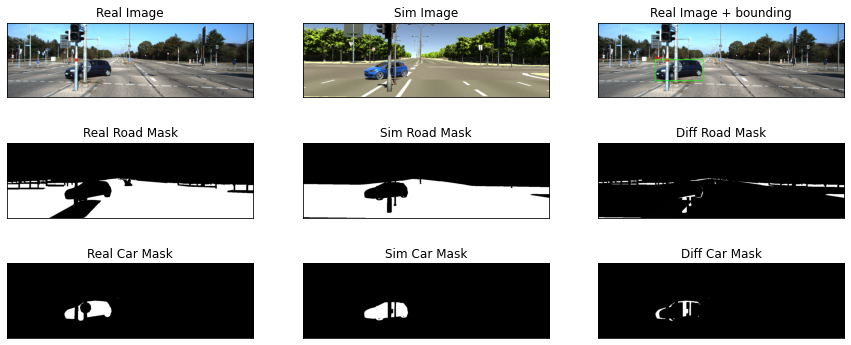

0018
0018


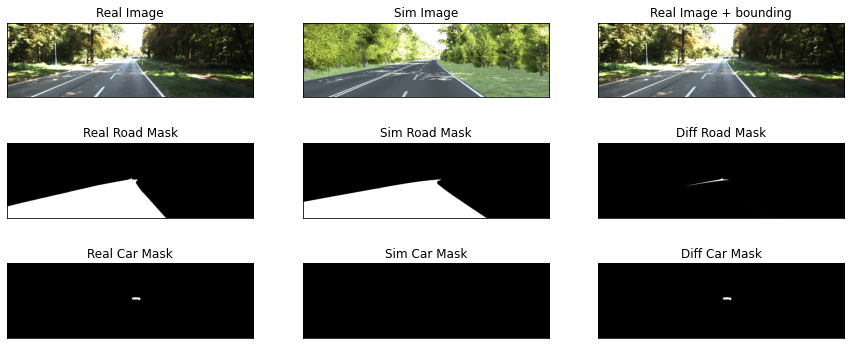

0020
0020


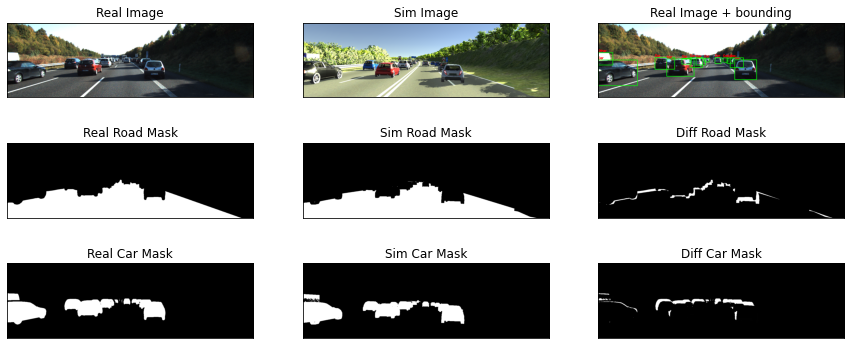

In [29]:
for dataset_index in dataset_index_list_test:
  print(dataset_index)
  print(dataset_index)
  for i in range(0, 1):
      fig, axs = plt.subplots(3, 3, figsize=(15, 6))
      plt.subplots_adjust(wspace=0.2, hspace=0.4)

      axs[0,0].imshow(cv2.cvtColor(loaded_dictionary_images_real[dataset_index][i], cv2.COLOR_BGR2RGB))
      axs[0,0].set_title('Real Image')
      axs[0,1].imshow(cv2.cvtColor(loaded_dictionary_images_sim[dataset_index][i], cv2.COLOR_BGR2RGB))
      axs[0,1].set_title('Sim Image')

      img=loaded_dictionary_images_real[dataset_index][i].copy()

      if i in boxes_real_dict[dataset_index]:
          for label, x_min, y_min, x_max, y_max in boxes_real_dict[dataset_index][i]:
              if label==3:
                  label_text="Car"
              else:
                  label_text="Other"
              if x_max > x_min and y_max > y_min:
                  cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                  cv2.putText(img, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
      
      axs[0,2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      axs[0,2].set_title('Real Image + bounding')


      desired_semantic_id = 0
      binary_mask_real = (loaded_semantic_id_real[dataset_index][i] == desired_semantic_id).astype(np.uint8)
      binary_mask_fake = (loaded_semantic_id_sim[dataset_index][i] == desired_semantic_id).astype(np.uint8)


      diff_mask_road=abs(binary_mask_fake-binary_mask_real)

      axs[1, 0].imshow(binary_mask_real, cmap='gray')
      axs[1, 0].set_title('Real Road Mask')

      axs[1, 1].imshow(binary_mask_fake, cmap='gray')
      axs[1, 1].set_title('Sim Road Mask')

      axs[1, 2].imshow(diff_mask_road, cmap='gray')
      axs[1, 2].set_title('Diff Road Mask')

      desired_semantic_id = 13
      binary_mask_real = (loaded_semantic_id_real[dataset_index][i] == desired_semantic_id).astype(np.uint8)
      binary_mask_fake = (loaded_semantic_id_sim[dataset_index][i] == desired_semantic_id).astype(np.uint8)


      diff_mask_road=abs(binary_mask_fake-binary_mask_real)

      axs[2, 0].imshow(binary_mask_real, cmap='gray')
      axs[2, 0].set_title('Real Car Mask')

      axs[2, 1].imshow(binary_mask_fake, cmap='gray')
      axs[2, 1].set_title('Sim Car Mask')

      axs[2, 2].imshow(diff_mask_road, cmap='gray')
      axs[2, 2].set_title('Diff Car Mask')

      for ax in axs.flat:
          ax.set_xticks([])
          ax.set_yticks([])

      plt.show()

## Data generation

In [ ]:
model_type='real'
source_name='real'
yolo_runner(model_type,yolo,source_name,boxes_real_dict,class_names)

In [ ]:
model_type='sim'
source_name='sim'
yolo_runner(model_type,yolo,source_name,boxes_real_dict,class_names)

In [ ]:
model_type='cyclegan'
source_names=["cyclegan_1","cyclegan_2","cyclegan_3"]
for source_name in source_names:
    yolo_runner(model_type,yolo,source_name,boxes_real_dict,class_names)

In [ ]:
model_type='pix2pix_mask_manual'
source_names=["pix2pix_mask_1_sim","pix2pix_mask_2_sim","pix2pix_mask_3_sim"]
for source_name in source_names:
    yolo_runner(model_type,yolo,source_name,boxes_real_dict,class_names)